# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])

[nltk_data] Downloading package punkt to
[nltk_data]     /home/carolina.gomez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/carolina.gomez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/carolina.gomez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
# import libraries
import re
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

import pickle

import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
# load data from database
engine = create_engine('sqlite:///messagesdb.db')
df = pd.read_sql("SELECT * FROM messages", engine)
X = df['message']
Y = df.drop(['id', 'message', 'original', 'genre'], axis=1)

### 2. Write a tokenization function to process your text data

In [4]:
def tokenize(text):
    # normalize case and remove punctuation
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text.lower())
    # tokenize text
    tokens = word_tokenize(text)
    
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    # lemmatize and remove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [19]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [20]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x7fc98393fee0>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [25]:
y_pred = pipeline.predict(X_test)

In [34]:
def get_accuracy(y_test, y_pred):
    accuracy_df = pd.DataFrame(columns=['target_category', 'accuracy'])
    for ind, cat in enumerate(y_test):
        print('Target Category - {}'.format(cat))
        print(classification_report(y_test.values[ind], y_pred[ind]))
        accuracy = accuracy_score(y_test.values[ind], y_pred[ind])
        accuracy_df = accuracy_df.append({'target_category': cat, 'accuracy': accuracy}, ignore_index=True)
    return accuracy_df

In [35]:
random_forest_accuracy = get_accuracy(y_test, y_pred)

Target Category - related
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        29
           1       1.00      0.14      0.25         7

    accuracy                           0.83        36
   macro avg       0.91      0.57      0.58        36
weighted avg       0.86      0.83      0.78        36

Target Category - request
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        25
           1       1.00      0.09      0.17        11

    accuracy                           0.72        36
   macro avg       0.86      0.55      0.50        36
weighted avg       0.80      0.72      0.63        36

Target Category - offer
              precision    recall  f1-score   support

           0       1.00      0.91      0.96        35
           1       0.25      1.00      0.40         1

    accuracy                           0.92        36
   macro avg       0.62      0.96      0.68        3

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        36
           1       0.00      0.00      0.00         0

    accuracy                           0.89        36
   macro avg       0.50      0.44      0.47        36
weighted avg       1.00      0.89      0.94        36



/home/carolina.gomez/anaconda3/envs/ds-nano/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/carolina.gomez/anaconda3/envs/ds-nano/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/carolina.gomez/anaconda3/envs/ds-nano/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [36]:
random_forest_accuracy.head()

,target_category,accuracy
0,related,0.833333
1,request,0.722222
2,offer,0.916667
3,aid_related,0.833333
4,medical_help,0.861111


<AxesSubplot:title={'center':'RandomForestClassifier Accuracy'}, xlabel='target_category'>

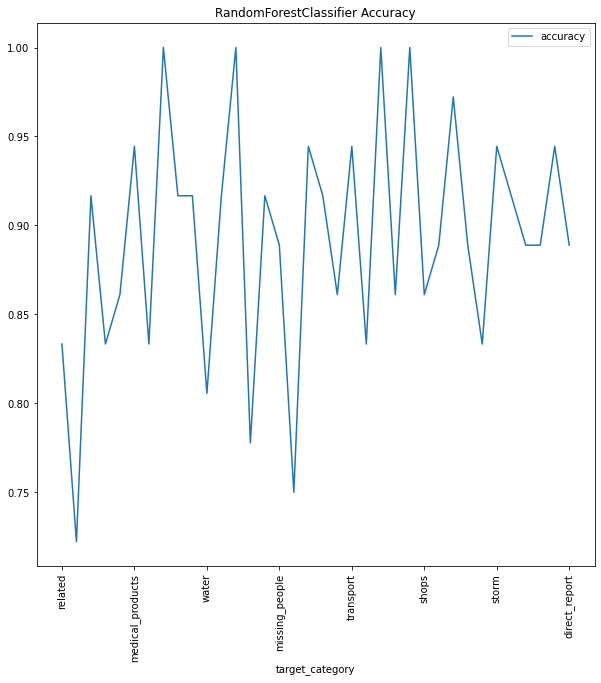

In [40]:
random_forest_accuracy.plot(x='target_category', y='accuracy', kind='line', title='RandomForestClassifier Accuracy', rot=90, figsize=(10, 10))

### 6. Improve your model
Use grid search to find better parameters. 

In [41]:
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x7fc98393fee0>)),
  ('tfidf', TfidfTransformer()),
  ('clf', MultiOutputClassifier(estimator=RandomForestClassifier()))],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x7fc98393fee0>),
 'tfidf': TfidfTransformer(),
 'clf': MultiOutputClassifier(estimator=RandomForestClassifier()),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tfidf_

In [21]:
parameters = {
    'clf__estimator__n_estimators': [50, 100, 200]
}

cv = GridSearchCV(pipeline, param_grid=parameters)
#This parameters couldn't be tested because it take so long to run.

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [22]:
# The error that is shown is because I interrup the execution because the optimization with GridSearch
# was taking so long so I decided to try other models.
cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)

KeyboardInterrupt: 

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

## DecisionTreeClassifier Model

In [8]:
pipeline_decision_tree = pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(DecisionTreeClassifier()))
])

In [9]:
pipeline_decision_tree.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x7fc98393fee0>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=DecisionTreeClassifier()))])

In [42]:
y_pred = pipeline_decision_tree.predict(X_test)

In [43]:
decision_tree_accuracy = get_accuracy(y_test, y_pred)

Target Category - related
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        29
           1       1.00      0.14      0.25         7

    accuracy                           0.83        36
   macro avg       0.91      0.57      0.58        36
weighted avg       0.86      0.83      0.78        36

Target Category - request
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        11

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

Target Category - offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00         1

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        3

<AxesSubplot:title={'center':'Classifiers Accuracy'}, xlabel='target_category'>

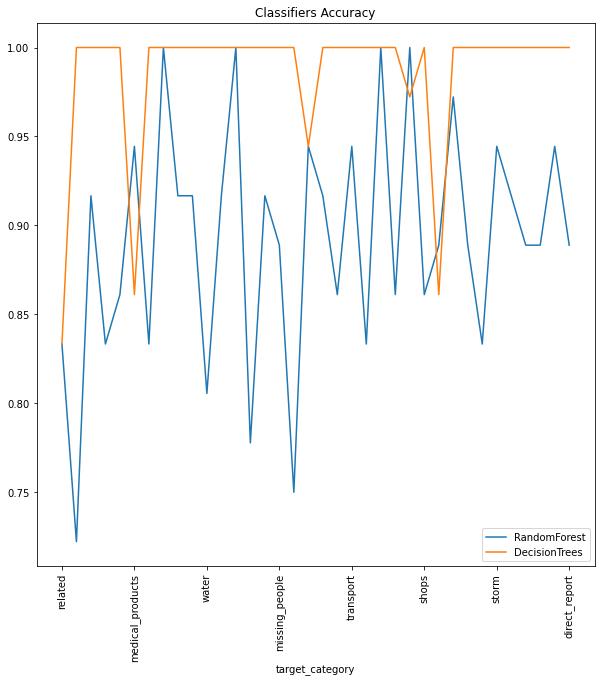

In [45]:
ax = random_forest_accuracy.plot(x='target_category', y='accuracy', kind='line', label='RandomForest',title='Classifiers Accuracy', rot=90, figsize=(10, 10))
decision_tree_accuracy.plot(x='target_category', y='accuracy', kind='line', ax=ax, label='DecisionTrees', rot=90)

## KNeighborsClassifier Model

In [46]:
pipeline_knn = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(KNeighborsClassifier()))
])

In [47]:
pipeline_knn.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x7fc98393fee0>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=KNeighborsClassifier()))])

In [48]:
y_pred = pipeline_knn.predict(X_test)

In [49]:
knn_accuracy = get_accuracy(y_test, y_pred)

Target Category - related
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        29
           1       1.00      0.14      0.25         7

    accuracy                           0.83        36
   macro avg       0.91      0.57      0.58        36
weighted avg       0.86      0.83      0.78        36

Target Category - request
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        25
           1       1.00      0.09      0.17        11

    accuracy                           0.72        36
   macro avg       0.86      0.55      0.50        36
weighted avg       0.80      0.72      0.63        36

Target Category - offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00         1

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        3

/home/carolina.gomez/anaconda3/envs/ds-nano/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/carolina.gomez/anaconda3/envs/ds-nano/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/carolina.gomez/anaconda3/envs/ds-nano/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

Target Category - aid_centers
              precision    recall  f1-score   support

           0       0.91      1.00      0.96        32
           1       1.00      0.25      0.40         4

    accuracy                           0.92        36
   macro avg       0.96      0.62      0.68        36
weighted avg       0.92      0.92      0.89        36

Target Category - other_infrastructure
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00         1

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

Targ

/home/carolina.gomez/anaconda3/envs/ds-nano/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/carolina.gomez/anaconda3/envs/ds-nano/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/carolina.gomez/anaconda3/envs/ds-nano/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

<AxesSubplot:title={'center':'Classifiers Accuracy'}, xlabel='target_category'>

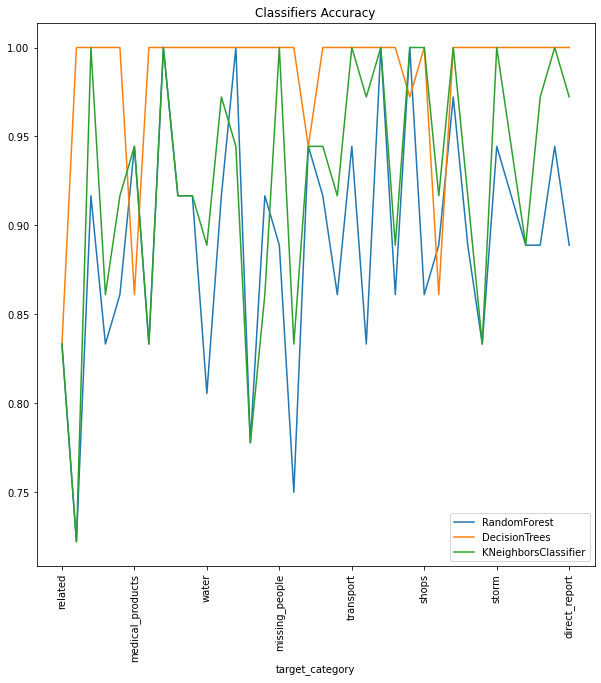

In [51]:
ax = random_forest_accuracy.plot(x='target_category', y='accuracy', kind='line', label='RandomForest',title='Classifiers Accuracy', rot=90, figsize=(10, 10))
ax1 = decision_tree_accuracy.plot(x='target_category', y='accuracy', kind='line', ax=ax, label='DecisionTrees', rot=90)
knn_accuracy.plot(x='target_category', y='accuracy', kind='line', ax=ax1, label='KNeighborsClassifier', rot=90)

In [52]:
print(f'RandomForest score: {pipeline.score(X_test, y_test)}')
print(f'DecisionTrees score: {pipeline_decision_tree.score(X_test, y_test)}')
print(f'KNeighborsClassifier score: {pipeline_knn.score(X_test, y_test)}')


RandomForest score: 0.8187366493744278
DecisionTrees score: 0.793561184009765
KNeighborsClassifier score: 0.263198046994202


# Improve the model

In [53]:
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x7fc98393fee0>)),
  ('tfidf', TfidfTransformer()),
  ('clf', MultiOutputClassifier(estimator=RandomForestClassifier()))],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x7fc98393fee0>),
 'tfidf': TfidfTransformer(),
 'clf': MultiOutputClassifier(estimator=RandomForestClassifier()),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tfidf_

In [55]:
parameters = {
    'clf__estimator__n_estimators': [100, 200, 300],
    'clf__estimator__min_samples_split': [2, 5, 10],
    'clf__estimator__max_features': ['auto', 'sqrt'],
    'clf__estimator__bootstrap': [True, False],
}

cv = GridSearchCV(pipeline, param_grid=parameters, cv=3)

In [56]:
cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x7fc98393fee0>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier()))]),
             param_grid={'clf__estimator__bootstrap': [True, False],
                         'clf__estimator__max_features': ['auto', 'sqrt'],
                         'clf__estimator__min_samples_split': [2, 5, 10],
                         'clf__estimator__n_estimators': [100, 200, 300]})

In [57]:
cv.best_params_

{'clf__estimator__bootstrap': True,
 'clf__estimator__max_features': 'sqrt',
 'clf__estimator__min_samples_split': 2,
 'clf__estimator__n_estimators': 200}

In [58]:
y_pred = cv.predict(X_test)

In [59]:
cv_accuracy = get_accuracy(y_test, y_pred)

Target Category - related
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        29
           1       1.00      0.14      0.25         7

    accuracy                           0.83        36
   macro avg       0.91      0.57      0.58        36
weighted avg       0.86      0.83      0.78        36

Target Category - request
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        25
           1       1.00      0.18      0.31        11

    accuracy                           0.75        36
   macro avg       0.87      0.59      0.58        36
weighted avg       0.82      0.75      0.68        36

Target Category - offer
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        35
           1       0.50      1.00      0.67         1

    accuracy                           0.97        36
   macro avg       0.75      0.99      0.83        3

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



/home/carolina.gomez/anaconda3/envs/ds-nano/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/carolina.gomez/anaconda3/envs/ds-nano/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/carolina.gomez/anaconda3/envs/ds-nano/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [60]:
print(f'RandomForest score: {cv.score(X_test, y_test)}')

RandomForest score: 0.2772352761672261


In [61]:
print(f'RandomForest score: {pipeline.score(X_test, y_test)}')

RandomForest score: 0.8187366493744278


<AxesSubplot:title={'center':'Classifiers Accuracy'}, xlabel='target_category'>

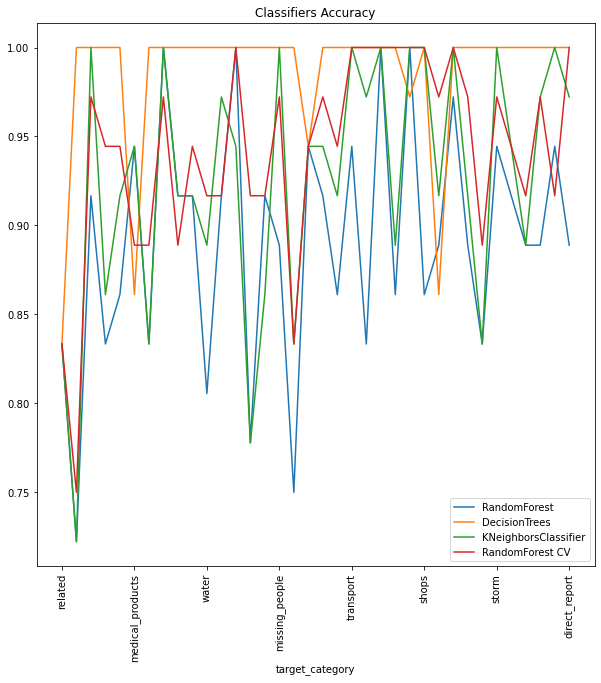

In [63]:
ax = random_forest_accuracy.plot(x='target_category', y='accuracy', kind='line', label='RandomForest',title='Classifiers Accuracy', rot=90, figsize=(10, 10))
ax1 = decision_tree_accuracy.plot(x='target_category', y='accuracy', kind='line', ax=ax, label='DecisionTrees', rot=90)
ax2 = knn_accuracy.plot(x='target_category', y='accuracy', kind='line', ax=ax1, label='KNeighborsClassifier', rot=90)
cv_accuracy.plot(x='target_category', y='accuracy', kind='line', label='RandomForest CV', rot=90, ax=ax2)

### 9. Export your model as a pickle file

In [62]:
with open('classifier_randomforest.pkl', 'wb') as f:
        pickle.dump(pipeline, f)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.